# VERIFICACIÓ DE LA SIMULACIÓ DEL TEMPS D'ESPERA

In [ ]:
import numpy as np
import pandas as pd
import simpy
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from concurrent.futures import ProcessPoolExecutor

# VARIABLES INICIALS
durada_simulacio = 12 * 60  # 12h en minuts
PACIENTA_MITJA = 45  # paciència mitjana del client (en minuts)

# DADES DE LES ATRACCIONS AMB DINÀMICA
atraccions_info = {
    'Big Thunder Mountain': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 30, 'nombre_vehicles': 5, 'temps_durada': 4,
        'temps_mitja_espera': 42,
        'tipus': ['nivell alt'], 'posicio': (10, 90), 'desitjat': 8.4
    },
    'Dumbo the Flying Elephant': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 3, 'nombre_vehicles': 18, 'temps_durada': 2,
        'temps_mitja_espera': 30,
        'tipus': ['infantil'], 'posicio': (20, 30), 'desitjat': 6.9
    },
    "Peter Pan's Flight": {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 4, 'nombre_vehicles': 16, 'temps_durada': 5,
        'temps_mitja_espera': 46,
        'tipus': ['infantil'], 'posicio': (25, 35), 'desitjat': 7.5
    },
    'Buzz Lightyear Lazer Blast': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 2, 'nombre_vehicles': 50, 'temps_durada': 4,
        'temps_mitja_espera': 32,
        'tipus': ['nivell mitja'], 'posicio': (50, 20), 'desitjat': 5
    },
    'Autopia': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 2, 'nombre_vehicles': 50, 'temps_durada': 5,
        'temps_mitja_espera': 27,
        'tipus': ['nivell alt'], 'posicio': (60, 70), 'desitjat': 5
    },
    'Phantom Manor': {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 3, 'nombre_vehicles': 131, 'temps_durada': 6,
        'temps_mitja_espera': 14,
        'tipus': ['nivell mitja'], 'posicio': (5, 95), 'desitjat': 8
    },
    "It's a small world": {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 20, 'nombre_vehicles': 24, 'temps_durada': 10,
        'temps_mitja_espera': 10,
        'tipus': ['infantil'], 'posicio': (30, 40), 'desitjat': 8
    },
    'Star Wars Hyperspace Mountain': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 32, 'nombre_vehicles': 7, 'temps_durada': 2,
        'temps_mitja_espera': 23,
        'tipus': ['nivell alt'], 'posicio': (70, 10), 'desitjat': 8.7
    },
    'Star Tours the Adventures Continue': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 25, 'nombre_vehicles': 4, 'temps_durada': 4,
        'temps_mitja_espera': 20,
        'tipus': ['nivell alt'], 'posicio': (75, 15), 'desitjat': 7.4
    },
    'Pirates of the Caribbean': {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 17, 'nombre_vehicles': 30, 'temps_durada': 12,
        'temps_mitja_espera': 18,
        'tipus': ['nivell mitja'], 'posicio': (15, 85), 'desitjat': 9.7
    },
    'Indiana Jones et el Temple du Peril': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 30, 'nombre_vehicles': 2, 'temps_durada': 1,
        'temps_mitja_espera': 19,
        'tipus': ['nivell alt'], 'posicio': (40, 50), 'desitjat': 9.5
    },
    'Mad Hatter’s Tea Cups': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 6, 'nombre_vehicles': 18, 'temps_durada': 2,
        'temps_mitja_espera': 10,
        'tipus': ['infantil'], 'posicio': (35, 45), 'desitjat': 5
    }
}
def espera_omnimover(cua, atraccio, params):
    info = params['atraccions_info'][atraccio]
    cap_vehicle = info['persones_per_vehicle']
    n_veh = info['nombre_vehicles']
    durada = info['temps_durada']
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0

    taxa_servei = (n_veh * cap_vehicle) / durada
    return n_clients / taxa_servei

def espera_simultanea(cua, atraccio, params):
    info = params['atraccions_info'][atraccio]
    cap_total = info['persones_per_vehicle'] * info['nombre_vehicles']
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0
    tornades_abans = math.floor((n_clients - 1) / cap_total)
    return tornades_abans * info['temps_durada'] + params['atraccions_info'][atraccio]['temps_durada']

def espera_blockchain(cua, atraccio, params):
    info = params['atraccions_info'][atraccio]
    cap_vehicle = info['persones_per_vehicle']
    n_vehicles  = info['nombre_vehicles']
    durada_via  = info['temps_durada']

    capacitat_total = cap_vehicle * n_vehicles
    headway = durada_via / n_vehicles
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0

    rotacions = math.ceil(n_clients / cap_vehicle)

    espera_per_cua = headway * (rotacions - 1) * cap_vehicle / cap_vehicle

    return espera_per_cua + durada_via

def calcula_espera(cua, atraccio, params):
    dinamica = params['atraccions_info'][atraccio]['dinamica']

    if dinamica == 'simultanea':
        return espera_simultanea(cua, atraccio, params)
    elif dinamica == 'omnimover':
        return espera_omnimover(cua, atraccio, params)
    elif dinamica == 'blockchain':
        return espera_blockchain(cua, atraccio, params)
    else:
        raise ValueError(f"Tipus de dinàmica desconeguda: {dinamica}")

def generar_preferencies():
    preferencies_tipus = ['infantil', 'nivell alt', 'nivell mitja']
    preferencies = random.sample(preferencies_tipus, random.randint(1, len(preferencies_tipus)))
    return preferencies

def distancia(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def client(env, nom, cues, dades, paciencia, preferencies, params):
    registre = {
        'Client': nom,
        'Paciencia': paciencia,
        'Atraccions': [],
        'TempsArribades': [],
        'EsperesReals': [],
        'Abandonaments': 0,
        'TempsTotal': 0,
        'Valoracions': {},
        'Preferencies': preferencies
    }

    temps_inici = env.now
    posicio_actual = (0, 0)
    posicions_clients = {}
    posicions_clients[nom] = {'pos': posicio_actual, 'estat': 'moviment'}

    matching_atraccions = [
        a for a in params['atraccions_info']
        if any(tipus in params['atraccions_info'][a]['tipus'] for tipus in preferencies)
    ]

    atraccions_pendents = []

    if matching_atraccions:
        n = random.randint(6, 10)
        n = min(n, len(matching_atraccions))

        attractions = matching_atraccions.copy()
        weights = np.array([params['atraccions_info'][a]['desitjat'] for a in attractions], dtype=float)
        weights = weights / weights.sum()
        selected_idx = np.random.choice(len(attractions), size=n, replace=False, p=weights)
        atraccions_pendents = [attractions[i] for i in selected_idx]

    atraccions_abandonades = []

    while (atraccions_pendents or atraccions_abandonades) and env.now - temps_inici <= params['durada_simulacio']:
        if atraccions_pendents:
            llista_actual = atraccions_pendents
        else:
            llista_actual = atraccions_abandonades

        esperes = {a: calcula_espera(cues[a], a, params) for a in llista_actual}
        if not esperes:
            break

        millor_espera = min(esperes.values())
        candidats = [a for a in esperes if esperes[a] == millor_espera]

        if len(candidats) > 1:
            atraccio = min(candidats, key=lambda a: distancia(posicio_actual, params['atraccions_info'][a]['posicio']))
        else:
            atraccio = candidats[0]

        if esperes[atraccio] > paciencia:
            if atraccio in atraccions_pendents:
                atraccions_pendents.remove(atraccio)
                atraccions_abandonades.append(atraccio)
            elif atraccio in atraccions_abandonades:
                atraccions_abandonades.remove(atraccio)
            registre['Abandonaments'] += 1
            registre['Atraccions'].append(f"{atraccio} (X)")
            registre['TempsArribades'].append(env.now)
            registre['EsperesReals'].append(paciencia)
            registre['Valoracions'][f"{atraccio} (X)"] = 0
            posicions_clients[nom]['estat'] = 'abandonat'
            continue

        distancia_mou = distancia(posicio_actual, params['atraccions_info'][atraccio]['posicio'])
        temps_moviment = max(1, int(distancia_mou / params['velocitat_client']))
        yield env.timeout(temps_moviment)
        temps_arribada = env.now
        posicio_actual = params['atraccions_info'][atraccio]['posicio']
        posicions_clients[nom]['pos'] = posicio_actual
        posicions_clients[nom]['estat'] = 'cua'

        start_wait = env.now
        if params['atraccions_info'][atraccio]['dinamica'] == 'simultanea':
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                stop_wait = env.now
                yield env.timeout(params['atraccions_info'][atraccio]['temps_durada'])

        elif params['atraccions_info'][atraccio]['dinamica'] == 'omnimover':
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                yield env.timeout(0.5)
                stop_wait = env.now
                yield env.timeout(params['atraccions_info'][atraccio]['temps_durada'])

        else:
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                stop_wait = env.now
                yield env.timeout(params['atraccions_info'][atraccio]['temps_durada'])

        temps_a_cua = stop_wait - start_wait

        if req not in result:
            if atraccio in atraccions_pendents:
                atraccions_pendents.remove(atraccio)
                atraccions_abandonades.append(atraccio)
            registre['Abandonaments'] += 1
            registre['Atraccions'].append(f"{atraccio} (X)")
            registre['TempsArribades'].append(env.now)
            registre['EsperesReals'].append(temps_a_cua)
            registre['Valoracions'][f"{atraccio} (X)"] = 0
            posicions_clients[nom]['estat'] = 'abandonat'
            continue

        posicions_clients[nom]['estat'] = 'atraccio'

        registre['EsperesReals'].append(temps_a_cua)
        registre['Atraccions'].append(atraccio)
        registre['TempsArribades'].append(temps_arribada)

        if atraccio in atraccions_pendents:
            atraccions_pendents.remove(atraccio)
        elif atraccio in atraccions_abandonades:
            atraccions_abandonades.remove(atraccio)

    if registre['Atraccions']:
        for atraccio in registre['Atraccions']:
            if '(X)' not in atraccio:
                registre['Valoracions'][atraccio] = random.uniform(0, 10)

    atraccions_visitades = [a for a in registre['Valoracions'] if '(X)' not in a]
    atraccions_visitades_ordenades = sorted(atraccions_visitades, key=lambda x: registre['Valoracions'][x], reverse=True)

    while atraccions_visitades_ordenades and env.now - temps_inici <= params['durada_simulacio']:
        atraccio = atraccions_visitades_ordenades[0]

        distancia_mou = distancia(posicio_actual, params['atraccions_info'][atraccio]['posicio'])
        temps_moviment = max(1, int(distancia_mou / params['velocitat_client']))
        yield env.timeout(temps_moviment)
        temps_arribada = env.now
        posicio_actual = params['atraccions_info'][atraccio]['posicio']
        posicions_clients[nom]['pos'] = posicio_actual
        posicions_clients[nom]['estat'] = 'cua'

        with cues[atraccio].request() as req:
            start_wait = env.now
            result = yield req | env.timeout(paciencia)

            if req not in result:
                registre['Abandonaments'] += 1
                temps_a_cua = env.now - start_wait
                registre['Atraccions'].append(f"{atraccio} (X) (REP)")
                registre['TempsArribades'].append(env.now)
                registre['EsperesReals'].append(temps_a_cua)
                registre['Valoracions'][f"{atraccio} (X) (REP)"] = 0
                posicions_clients[nom]['estat'] = 'abandonat'
                atraccions_visitades_ordenades.pop(0)
                continue

            espera_real = env.now - start_wait
            registre['EsperesReals'].append(espera_real)
            registre['Atraccions'].append(f"{atraccio} (REP)")
            registre['TempsArribades'].append(temps_arribada)
            registre['Valoracions'][f"{atraccio} (REP)"] = random.uniform(0, 10)

            posicions_clients[nom]['estat'] = 'atraccio'
            yield env.timeout(params['atraccions_info'][atraccio]['temps_durada'])

    registre['TempsTotal'] = env.now

    dades.append(registre)

def prepara_clients(total_clients, paciencia_mitjana=45, paciencia_desv=10):
    clients = []
    for i in range(total_clients):
        paciencia = max(5, np.random.normal(paciencia_mitjana, paciencia_desv))
        preferencies = generar_preferencies()
        clients.append((f'Client_{i:05d}', paciencia, preferencies))
    return clients

def run_single_simulacio(simulacio_params):
    sim_id = simulacio_params['sim_id']
    total_clients = simulacio_params['total_clients']
    paciencia_mitjana = simulacio_params['paciencia_mitjana']
    paciencia_desv = simulacio_params['paciencia_desv']
    velocitat_client = simulacio_params['velocitat_client']
    durada_simulacio = simulacio_params['durada_simulacio']
    atraccions_info = simulacio_params['atraccions_info'].copy()

    print(f"Iniciant simulació {sim_id}...")

    env = simpy.Environment()
    cues = {}
    for nom, info in atraccions_info.items():
        if info['dinamica'] == 'simultanea':
            capacity = info['persones_per_vehicle'] * info['nombre_vehicles']
        elif info['dinamica'] == 'omnimover':
            capacity = info['persones_per_vehicle'] * info['nombre_vehicles']
        else:#(blockchain)
            capacity = info['persones_per_vehicle']
        cues[nom] = simpy.Resource(env, capacity=capacity)

    dades = []

    clients = prepara_clients(total_clients, paciencia_mitjana, paciencia_desv)

    params = {
        'atraccions_info': atraccions_info,
        'durada_simulacio': durada_simulacio,
        'velocitat_client': velocitat_client
    }

    for client_id, paciencia, preferencies in clients:
        env.process(client(
            env,
            client_id,
            cues,
            dades,
            paciencia,
            preferencies,
            params
        ))

    env.run()

    resultats = calcular_metriques(dades, atraccions_info)
    resultats['sim_id'] = sim_id

    print(f"Simulació {sim_id} completada")
    return resultats


def calcular_metriques(dades, atraccions_info):
    """Calcula las métricas de interés para cada atracción basándose en los datos recopilados"""
    df = pd.DataFrame(dades)

    metriques_atraccions = {}

    totes_les_atraccions = []
    for atracs in df['Atraccions']:
        for atrac in atracs:
            nom_atraccio = atrac.split(" (")[0]  # Eliminem marcadors com (X) i (REP)
            totes_les_atraccions.append(nom_atraccio)

    comptador_atraccions = {}
    for atraccio in atraccions_info.keys():
        comptador_atraccions[atraccio] = totes_les_atraccions.count(atraccio)

    espera_per_atraccio = {}
    abandons_per_atraccio = {}

    for idx, client in df.iterrows():
        for i, atraccio_full in enumerate(client['Atraccions']):
            nom_atraccio = atraccio_full.split(" (")[0]  # Eliminem marcadors (X) o (REP)

            es_abandono = "(X)" in atraccio_full

            if nom_atraccio not in espera_per_atraccio:
                espera_per_atraccio[nom_atraccio] = []
                abandons_per_atraccio[nom_atraccio] = 0

            temps_espera = client['EsperesReals'][i]
            espera_per_atraccio[nom_atraccio].append(temps_espera)

            if es_abandono:
                abandons_per_atraccio[nom_atraccio] += 1

    for atraccio in atraccions_info.keys():
        if atraccio in espera_per_atraccio and espera_per_atraccio[atraccio]:
            temps_mig = np.mean(espera_per_atraccio[atraccio])
            total_visites = len(espera_per_atraccio[atraccio])
            taxa_abandon = abandons_per_atraccio[atraccio] / total_visites if total_visites > 0 else 0
        else:
            temps_mig = 0
            total_visites = 0
            taxa_abandon = 0

        metriques_atraccions[atraccio] = {
            'visites_totals': total_visites,
            'temps_espera_mig': temps_mig,
            'taxa_abandonament': taxa_abandon
        }

    # Mètriques globals
    abandonaments_totals = df['Abandonaments'].sum()
    clients_totals = len(df)
    atraccions_per_client = np.mean([len([a for a in atracs if '(X)' not in a]) for atracs in df['Atraccions']])
    temps_total_mig = df['TempsTotal'].mean()

    resultats = {
        'metriques_atraccions': metriques_atraccions,
        'abandonaments_totals': abandonaments_totals,
        'clients_totals': clients_totals,
        'atraccions_per_client': atraccions_per_client,
        'temps_total_mig': temps_total_mig
    }

    return resultats

def run_montecarlo_simulacio(n_simulacions=30):
    """
    Executa múltiples simulacions amb paràmetres aleatoris per fer una anàlisi Monte Carlo
    """
    simulacions_params = []

    # Generem paràmetres aleatoris per cada simulació
    for sim_id in range(n_simulacions):
        total_clients = int(np.random.normal(12000, 1000))  # Num clients
        paciencia_mitjana = np.random.normal(45, 5)  # Paciencia mitjana
        paciencia_desv = np.random.normal(10, 2)  # Desviació de paciencia
        velocitat_client = np.random.normal(5, 0.5)  # Vel. de moviment
        durada_sim = np.random.normal(12 * 60, 60)  # Duració de simulació

        # Variem lleugerament els paràmetres de les atraccions:
        atraccions_modificades = atraccions_info.copy()
        for nom_atraccio, info in atraccions_modificades.items():
            info_mod = info.copy()

            # Variem temps de duració
            factor_durada = np.random.normal(1.0, 0.1)  # Factor de 0.9 a 1.1
            info_mod['temps_durada'] = max(1, info['temps_durada'] * factor_durada)

            # Variem num de vehicles
            if info['nombre_vehicles'] > 1:
                variacio = np.random.randint(-1, 2)  # -1, 0, o 1
                info_mod['nombre_vehicles'] = max(1, info['nombre_vehicles'] + variacio)

            atraccions_modificades[nom_atraccio] = info_mod

        params = {
            'sim_id': sim_id,
            'total_clients': total_clients,
            'paciencia_mitjana': paciencia_mitjana,
            'paciencia_desv': paciencia_desv,
            'velocitat_client': velocitat_client,
            'durada_simulacio': durada_sim,
            'atraccions_info': atraccions_modificades
        }

        simulacions_params.append(params)

    # Executem les simulacions
    resultats_simulacions = []

    print(f"Executant {n_simulacions} simulacions...")
    for params in simulacions_params:
        resultats_simulacions.append(run_single_simulacio(params))

    return simulacions_params, resultats_simulacions

def analitzar_resultats(resultats_simulacions):
    """
    Analitza els resultats de múltiples simulacions per calcular barres d'error
    i generar gràfiques amb les distribucions.
    """
    metriques_globals = pd.DataFrame([
        {
            'sim_id': r['sim_id'],
            'abandonaments_totals': r['abandonaments_totals'],
            'clients_totals': r['clients_totals'],
            'atraccions_per_client': r['atraccions_per_client'],
            'temps_total_mig': r['temps_total_mig']
        } for r in resultats_simulacions
    ])

    # métriques atraccions:
    metriques_atraccions = []
    for r in resultats_simulacions:
        sim_id = r['sim_id']
        for atraccio, metriques in r['metriques_atraccions'].items():
            metriques_atraccions.append({
                'sim_id': sim_id,
                'atraccio': atraccio,
                'visites_totals': metriques['visites_totals'],
                'temps_espera_mig': metriques['temps_espera_mig'],
                'taxa_abandonament': metriques['taxa_abandonament']
            })

    df_atraccions = pd.DataFrame(metriques_atraccions)

    # estadístiques i barres d'error (media ± desviación estándar)
    temps_espera_stats = df_atraccions.groupby('atraccio')['temps_espera_mig'].agg(['mean', 'std']).reset_index()
    visites_stats = df_atraccions.groupby('atraccio')['visites_totals'].agg(['mean', 'std']).reset_index()
    abandons_stats = df_atraccions.groupby('atraccio')['taxa_abandonament'].agg(['mean', 'std']).reset_index()

    # estadístiques globals
    globals_stats = {
        'abandonaments': {
            'mean': metriques_globals['abandonaments_totals'].mean(),
            'std': metriques_globals['abandonaments_totals'].std()
        },
        'atraccions_per_client': {
            'mean': metriques_globals['atraccions_per_client'].mean(),
            'std': metriques_globals['atraccions_per_client'].std()
        },
        'temps_total': {
            'mean': metriques_globals['temps_total_mig'].mean(),
            'std': metriques_globals['temps_total_mig'].std()
        }
    }

    return {
        'temps_espera_stats': temps_espera_stats,
        'visites_stats': visites_stats,
        'abandons_stats': abandons_stats,
        'globals_stats': globals_stats,
        'df_atraccions': df_atraccions,
        'metriques_globals': metriques_globals
    }

def visualitzar_resultats(resultats_analisis):
    """
    Genera visualitzacions de les barres d'error i distribucions dels resultats.
    """
    # Configuració pels gràfics
    #plt.style.use('seaborn')
    #plt.rcParams['figure.figsize'] = (12, 8)
    #plt.rcParams['font.size'] = 10

    # 1. Gràfic de barres amb barres derror per a temps despera
    fig, ax = plt.subplots(figsize=(14, 8))

    # Ordenem per temps mitjà d'espera descendent
    df_sorted = resultats_analisis['temps_espera_stats'].sort_values('mean', ascending=False)

    # Creem barres amb barres d'error
    ax.bar(df_sorted['atraccio'], df_sorted['mean'], yerr=df_sorted['std'],
        alpha=0.7, capsize=5, color='royalblue', ecolor='black')

    ax.set_title('Temps d\'espera mitjà per atracció amb barres d\'error (±σ)', fontsize=14)
    ax.set_xlabel('Atracció', fontsize=12)
    ax.set_ylabel('Temps d\'espera (minuts)', fontsize=12)
    ax.set_xticklabels(df_sorted['atraccio'], rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('temps_espera_barres_error.png', dpi=300)

    # 2. Gràfic amb distribucions de visites per atracció
    plt.figure(figsize=(14, 8))

    # Creem un gràfic de violí per mostrar la distribució
    sns.violinplot(x='atraccio', y='visites_totals', data=resultats_analisis['df_atraccions'],
                palette='viridis', inner='quartile')

    plt.title('Distribució de visites per atracció', fontsize=14)
    plt.xlabel('Atracció', fontsize=12)
    plt.ylabel('Nombre de visites', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('distribucio_visites.png', dpi=300)

    # 3. gràfic de taxes d'abandonament
    plt.figure(figsize=(14, 8))

    # ordenem per taxes d'abandonament
    df_sorted = resultats_analisis['abandons_stats'].sort_values('mean', ascending=False)

    # barres de error
    plt.bar(df_sorted['atraccio'], df_sorted['mean'], yerr=df_sorted['std'],
            alpha=0.7, capsize=5, color='firebrick', ecolor='black')

    plt.title('Taxa d\'abandonament per atracció amb barres d\'error (±σ)', fontsize=14)
    plt.xlabel('Atracció', fontsize=12)
    plt.ylabel('Taxa d\'abandonament', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('taxa_abandonament.png', dpi=300)

    # 4. Gràfic de distribució de temps d'espera per tipus d'atracció
    plt.figure(figsize=(14, 8))

    # Obtenim el tipus de atracció
    df_tipus = resultats_analisis['df_atraccions'].copy()
    df_tipus['tipus'] = df_tipus['atraccio'].apply(
        lambda x: ', '.join(atraccions_info[x]['tipus'])
    )

    # Gràfic de caixa per mostrar distribució per tipus
    sns.boxplot(x='tipus', y='temps_espera_mig', data=df_tipus)

    plt.title('Distribució de temps d\'espera per tipus d\'atracció', fontsize=14)
    plt.xlabel('Tipus d\'atracció', fontsize=12)
    plt.ylabel('Temps d\'espera mitjà (minuts)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('temps_espera_per_tipus.png', dpi=300)

    # 5. Gràfic de distribució de temps despera per dinàmica
    plt.figure(figsize=(14, 8))

    # Obtenim la dinàmica de cada atracció
    df_dinamica = resultats_analisis['df_atraccions'].copy()
    df_dinamica['dinamica'] = df_dinamica['atraccio'].apply(
        lambda x: atraccions_info[x]['dinamica']
    )

    # Gràfic de caixa per mostrar distribució per dinàmica
    sns.boxplot(x='dinamica', y='temps_espera_mig', data=df_dinamica)

    plt.title('Distribució de temps d\'espera per dinàmica d\'atracció', fontsize=14)
    plt.xlabel('Dinàmica', fontsize=12)
    plt.ylabel('Temps d\'espera mitjà (minuts)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('temps_espera_per_dinamica.png', dpi=300)

    # 6. Histograma d'abandonaments totals
    plt.figure(figsize=(12, 6))

    plt.hist(resultats_analisis['metriques_globals']['abandonaments_totals'], bins=15,
            alpha=0.7, color='orange', edgecolor='black')

    # Afegir línea vertical amb la mitjana
    plt.axvline(resultats_analisis['globals_stats']['abandonaments']['mean'],
                color='red', linestyle='dashed', linewidth=2,
                label=f'Mitjana: {resultats_analisis["globals_stats"]["abandonaments"]["mean"]:.2f}')

    # Afegir barras de error (media ± desviación)
    plt.axvspan(
        resultats_analisis['globals_stats']['abandonaments']['mean'] - resultats_analisis['globals_stats']['abandonaments']['std'],
        resultats_analisis['globals_stats']['abandonaments']['mean'] + resultats_analisis['globals_stats']['abandonaments']['std'],
        alpha=0.2, color='red', label=f'Desviació: ±{resultats_analisis["globals_stats"]["abandonaments"]["std"]:.2f}'
    )

    plt.title('Distribució d\'abandonaments totals', fontsize=14)
    plt.xlabel('Nombre d\'abandonaments', fontsize=12)
    plt.ylabel('Freqüència', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    plt.tight_layout()
    plt.savefig('distribucio_abandonaments.png', dpi=300)

    # 7. Histograma d'atraccions per client
    plt.figure(figsize=(12, 6))

    plt.hist(resultats_analisis['metriques_globals']['atraccions_per_client'], bins=15,
             alpha=0.7, color='green', edgecolor='black')

    # Afegir linia vertical amb la mitjana
    plt.axvline(resultats_analisis['globals_stats']['atraccions_per_client']['mean'],
                color='red', linestyle='dashed', linewidth=2,
                label=f'Mitjana: {resultats_analisis["globals_stats"]["atraccions_per_client"]["mean"]:.2f}')

    # Afegir barras de error (media ± desviación)
    plt.axvspan(
        resultats_analisis['globals_stats']['atraccions_per_client']['mean'] - resultats_analisis['globals_stats']['atraccions_per_client']['std'],
        resultats_analisis['globals_stats']['atraccions_per_client']['mean'] + resultats_analisis['globals_stats']['atraccions_per_client']['std'],
        alpha=0.2, color='red', label=f'Desviació: ±{resultats_analisis["globals_stats"]["atraccions_per_client"]["std"]:.2f}'
    )

    plt.title('Distribució d\'atraccions per client', fontsize=14)
    plt.xlabel('Nombre d\'atraccions', fontsize=12)
    plt.ylabel('Freqüència', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    plt.tight_layout()
    plt.savefig('distribucio_atraccions_per_client.png', dpi=300)

    print("Visualitzacions generades i guardades com a imatges.")


Executant 30 simulacions per anàlisis Monte Carlo...
Executant 30 simulacions...
Iniciant simulació 0...
Simulació 0 completada
Iniciant simulació 1...
Simulació 1 completada
Iniciant simulació 2...
Simulació 2 completada
Iniciant simulació 3...
Simulació 3 completada
Iniciant simulació 4...
Simulació 4 completada
Iniciant simulació 5...
Simulació 5 completada
Iniciant simulació 6...
Simulació 6 completada
Iniciant simulació 7...
Simulació 7 completada
Iniciant simulació 8...
Simulació 8 completada
Iniciant simulació 9...
Simulació 9 completada
Iniciant simulació 10...
Simulació 10 completada
Iniciant simulació 11...
Simulació 11 completada
Iniciant simulació 12...
Simulació 12 completada
Iniciant simulació 13...
Simulació 13 completada
Iniciant simulació 14...
Simulació 14 completada
Iniciant simulació 15...
Simulació 15 completada
Iniciant simulació 16...
Simulació 16 completada
Iniciant simulació 17...
Simulació 17 completada
Iniciant simulació 18...
Simulació 18 completada
Iniciant

C:\Users\nerea\AppData\Local\Temp\ipykernel_17368\1149872066.py:609: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_sorted['atraccio'], rotation=45, ha='right')
C:\Users\nerea\AppData\Local\Temp\ipykernel_17368\1149872066.py:619: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='atraccio', y='visites_totals', data=resultats_analisis['df_atraccions'],


Visualitzacions generades i guardades com a imatges.

Estadístiques principals:
Mitjana abandonaments: 80640.17 ± 11476.18
Mitjana atraccions per client: 17.48 ± 1.42
Temps total mitjà: 729.99 ± 32.20 minutos

Top 3 atraccions amb major temps d'espera:
Big Thunder Mountain: 45.00 ± 4.19 minutos
Peter Pan's Flight: 39.11 ± 3.94 minutos
Star Wars Hyperspace Mountain: 37.18 ± 3.83 minutos

Top 3 atraccions amb major taxa d'abandonament:
Big Thunder Mountain: 0.84 ± 0.03
Star Wars Hyperspace Mountain: 0.76 ± 0.04
Peter Pan's Flight: 0.49 ± 0.07

Anàlisi completat.


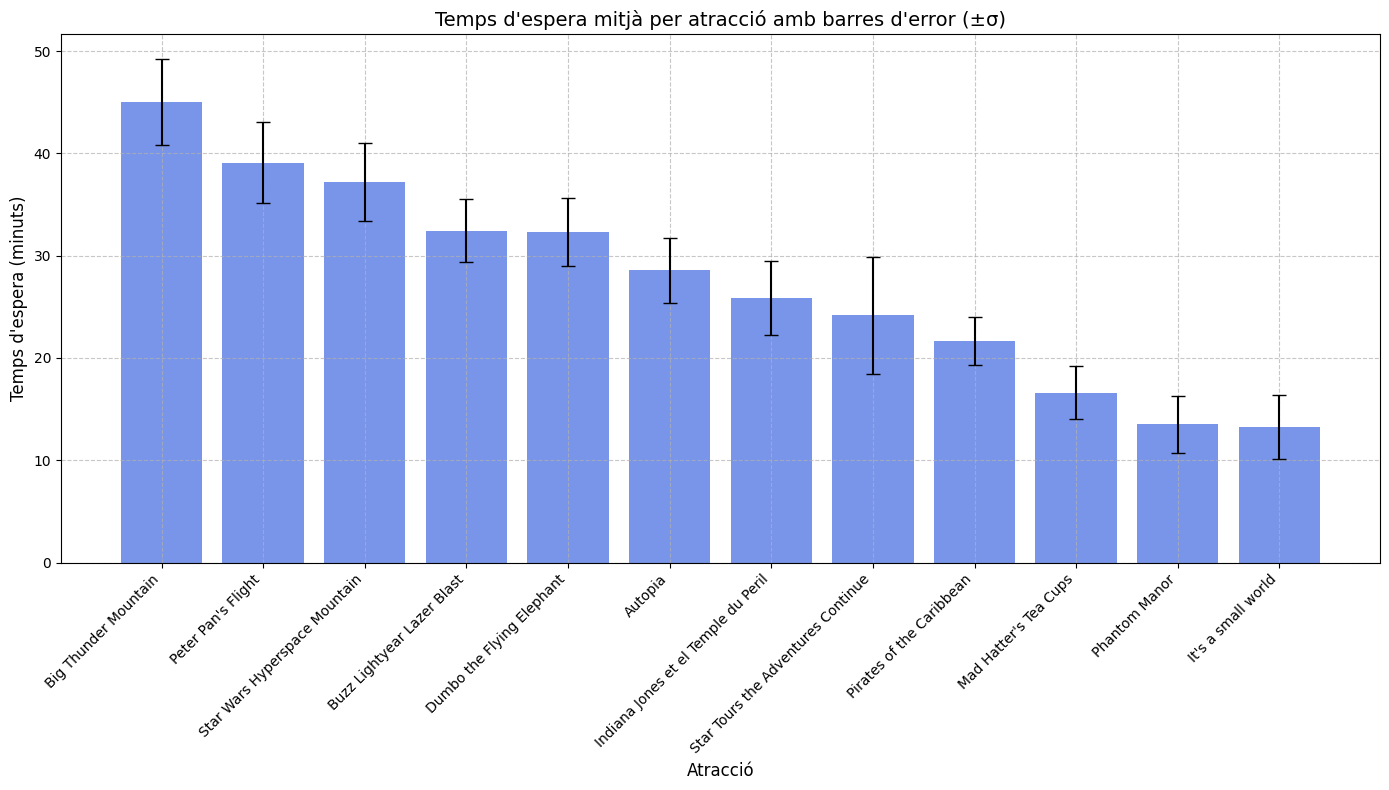

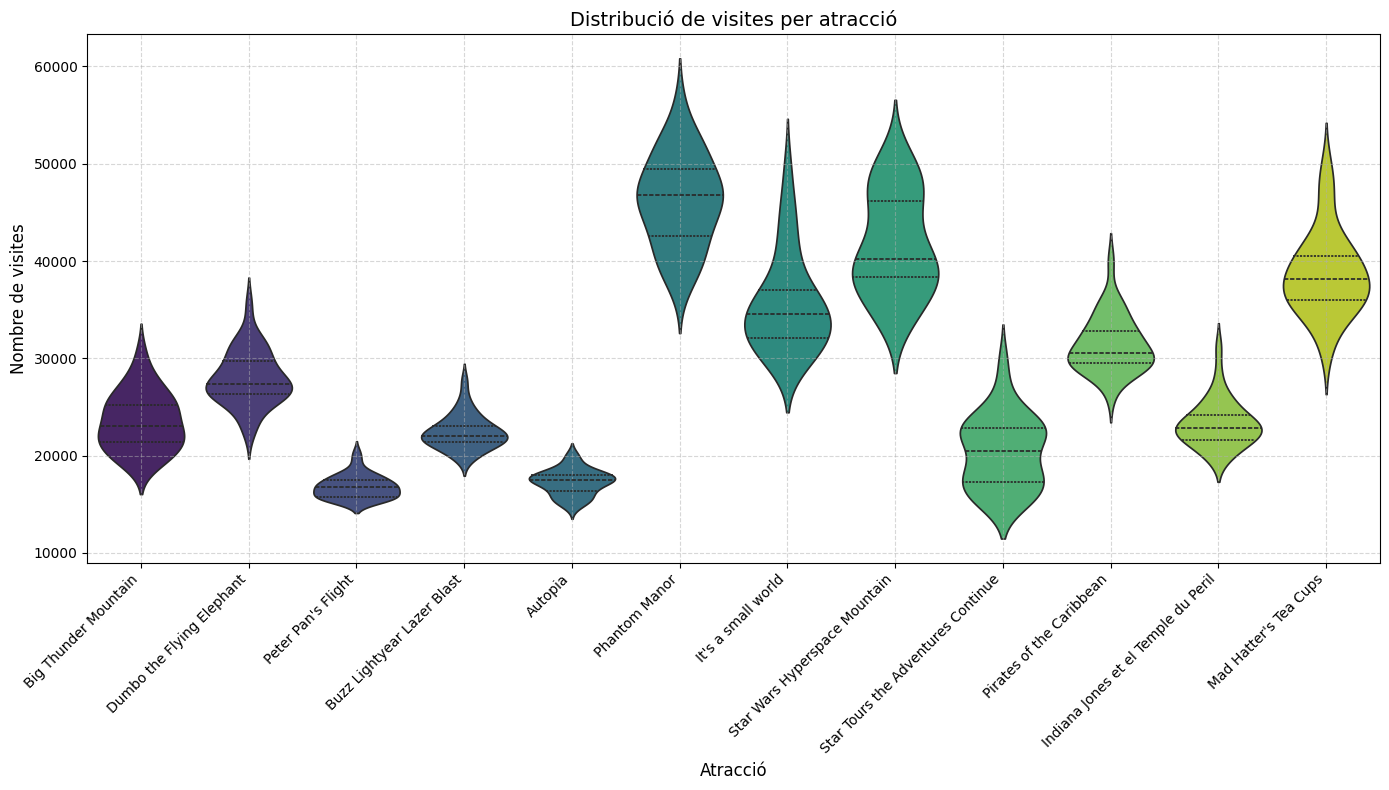

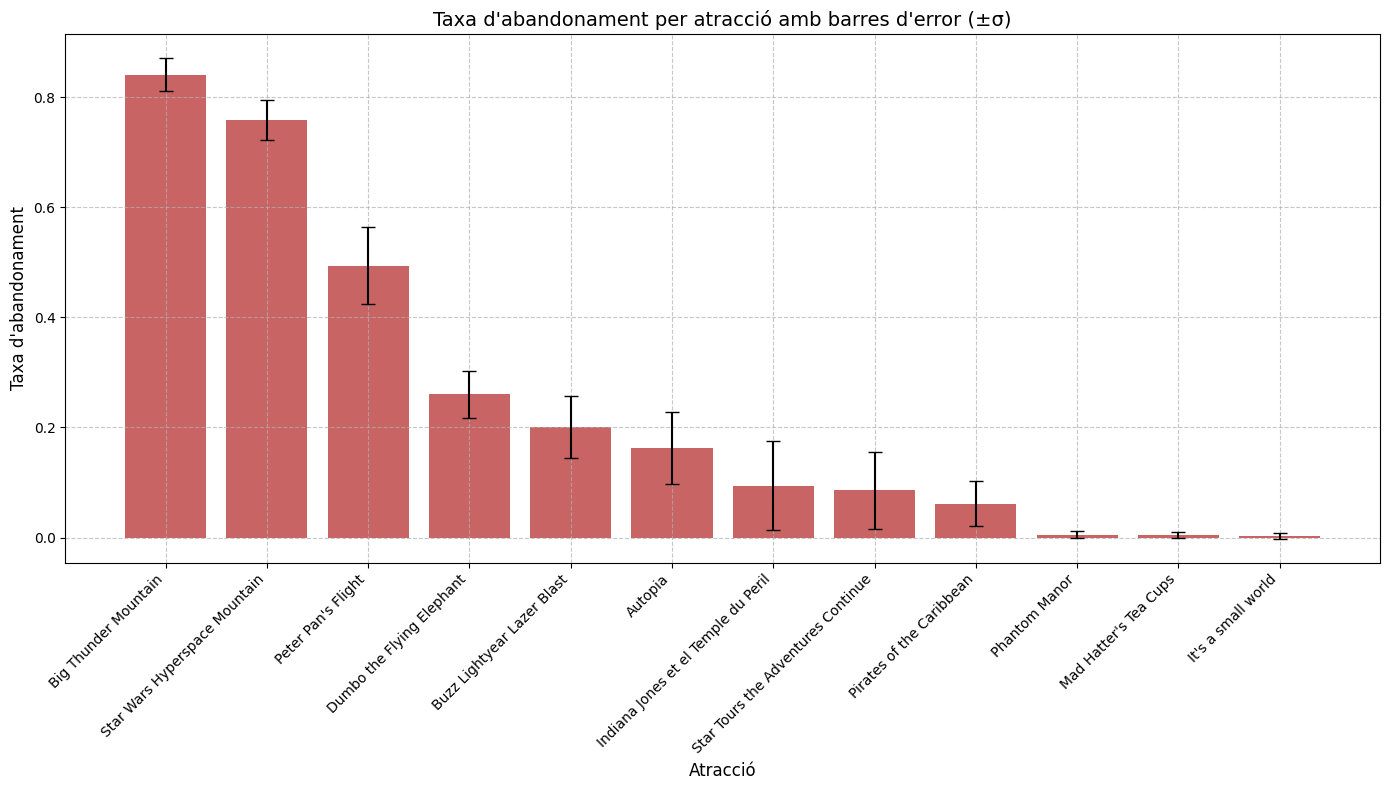

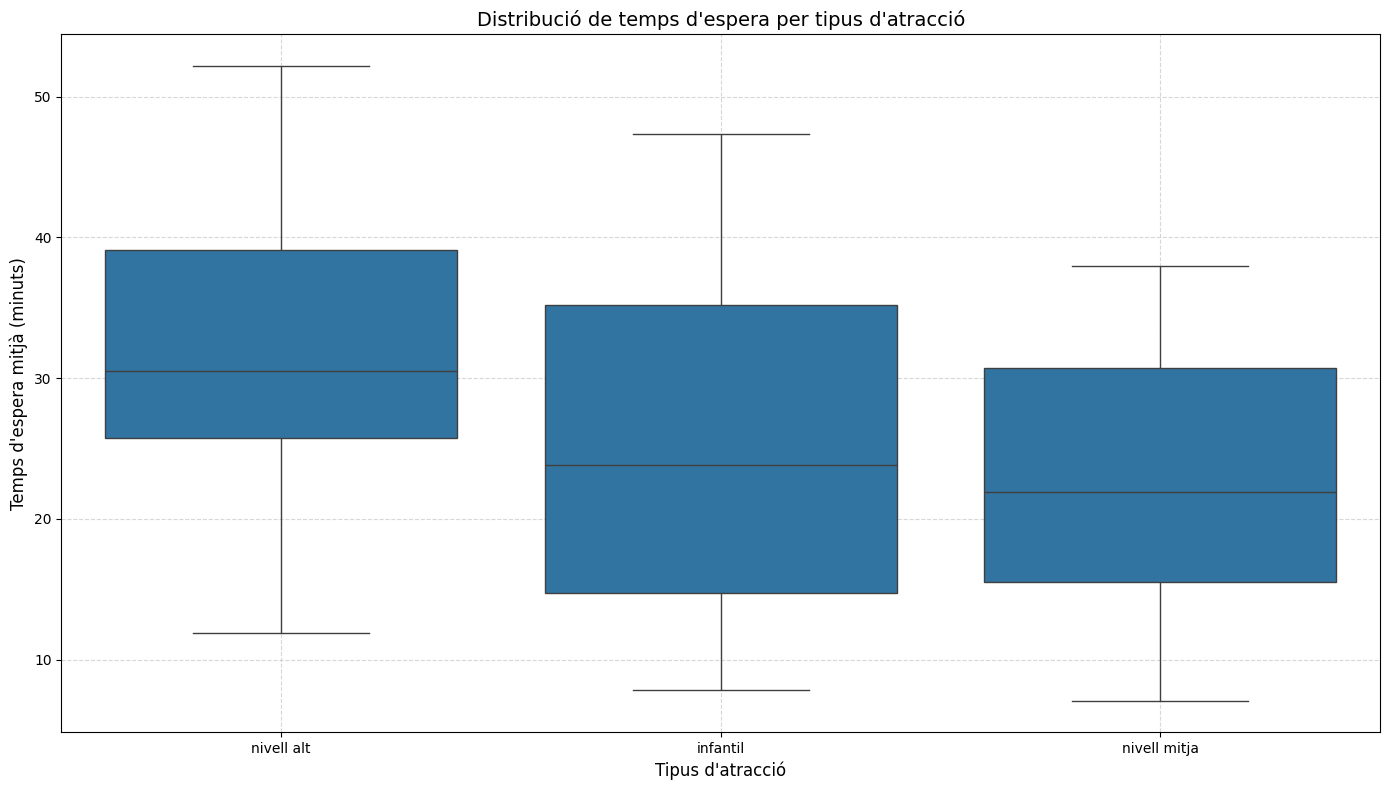

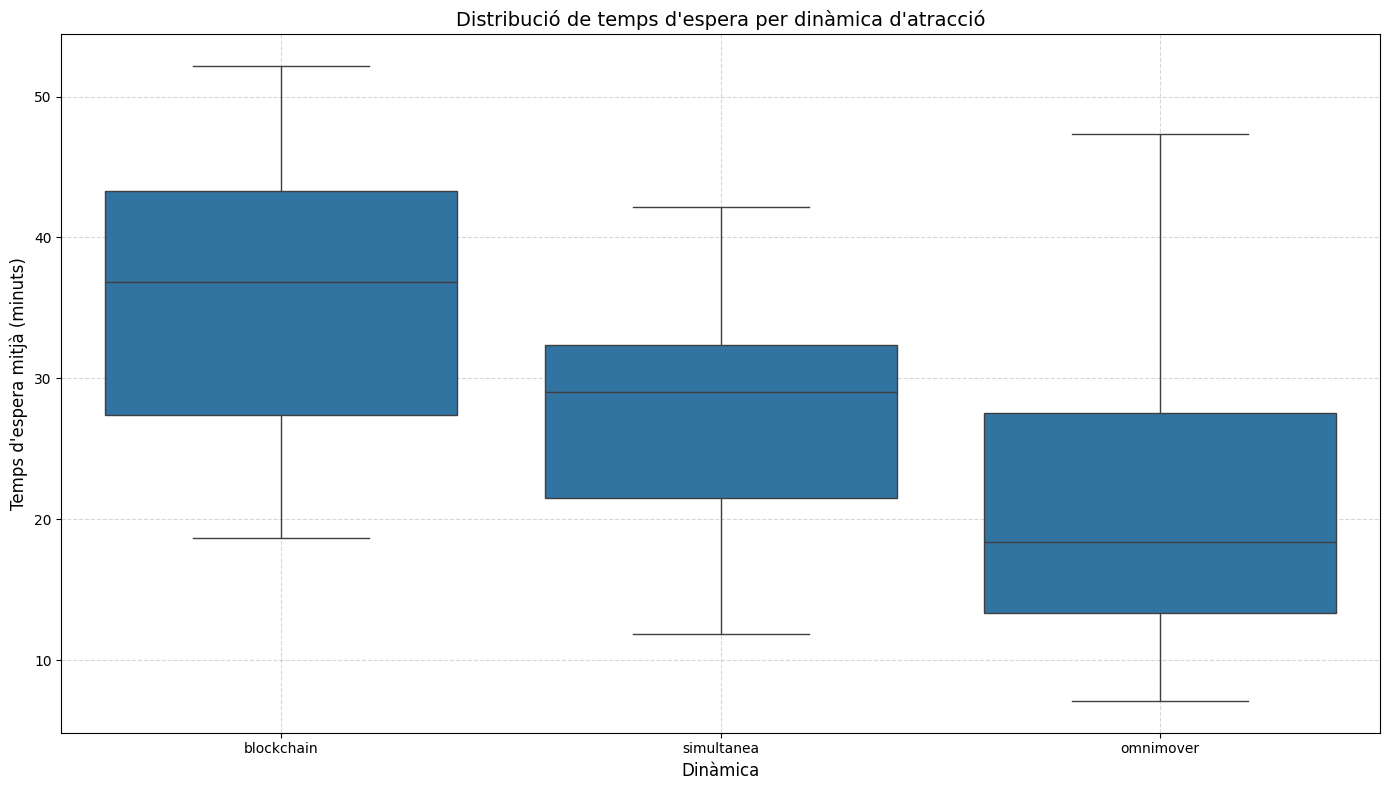

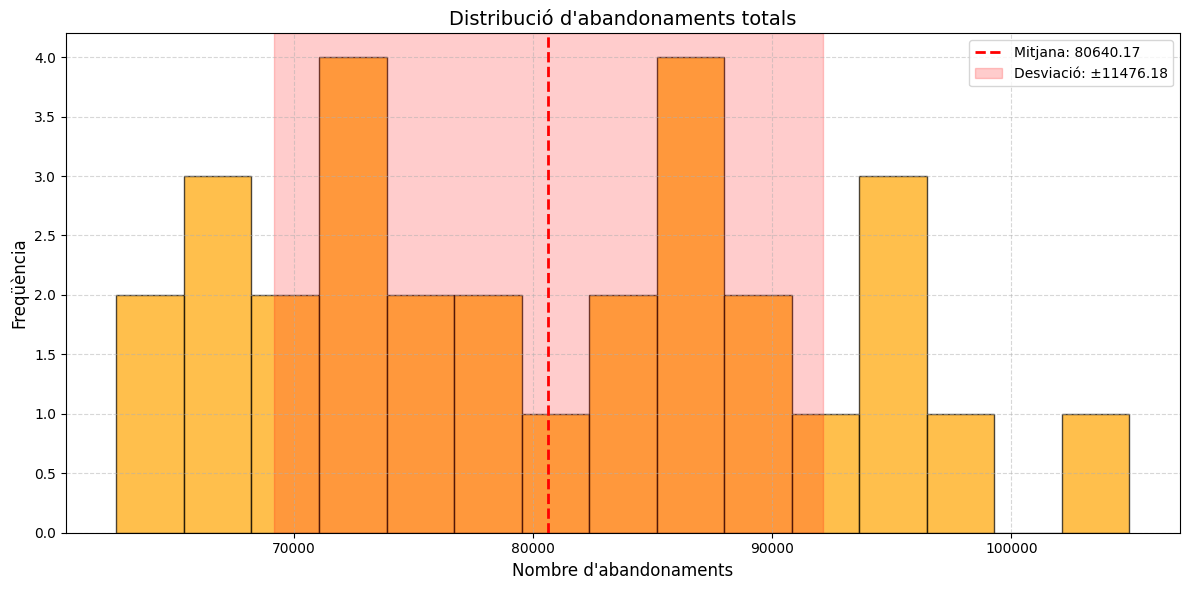

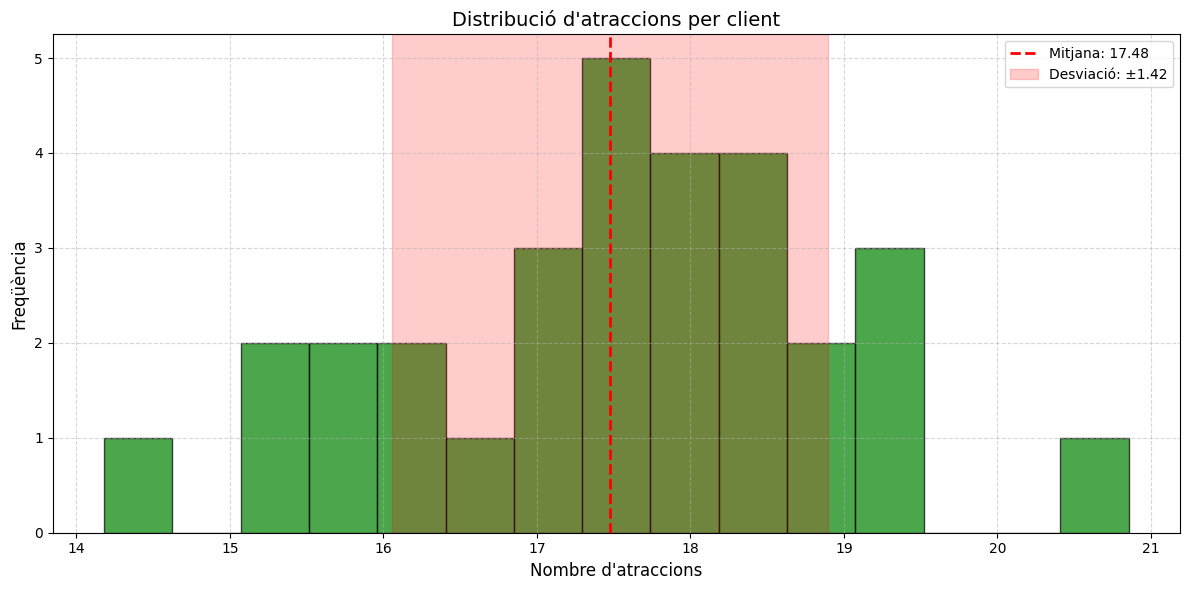

In [ ]:
"""
Funció principal que executa la simulació de Monte Carlo i genera les visualitzacions
"""
# Num de simulaciones per l'análisis de Monte Carlo
n_sims = 30

print(f"Executant {n_sims} simulacions per anàlisis Monte Carlo...")
start_time = time.time()

simulacions_params, resultats_simulacions = run_montecarlo_simulacio(n_sims)

end_time = time.time()
print(f"Simulacions completades en {(end_time - start_time)/60:.2f} minutos")

print("Analitzant resultats...")
resultats_analisis = analitzar_resultats(resultats_simulacions)

print("Generant visualitzacions...")
visualitzar_resultats(resultats_analisis)

# Mostrar algunes estadístiques
print("\nEstadístiques principals:")
print(f"Mitjana abandonaments: {resultats_analisis['globals_stats']['abandonaments']['mean']:.2f} ± {resultats_analisis['globals_stats']['abandonaments']['std']:.2f}")
print(f"Mitjana atraccions per client: {resultats_analisis['globals_stats']['atraccions_per_client']['mean']:.2f} ± {resultats_analisis['globals_stats']['atraccions_per_client']['std']:.2f}")
print(f"Temps total mitjà: {resultats_analisis['globals_stats']['temps_total']['mean']:.2f} ± {resultats_analisis['globals_stats']['temps_total']['std']:.2f} minutos")

print("\nTop 3 atraccions amb major temps d'espera:")
top_espera = resultats_analisis['temps_espera_stats'].sort_values('mean', ascending=False).head(3)
for _, row in top_espera.iterrows():
    print(f"{row['atraccio']}: {row['mean']:.2f} ± {row['std']:.2f} minutos")

print("\nTop 3 atraccions amb major taxa d'abandonament:")
top_abandons = resultats_analisis['abandons_stats'].sort_values('mean', ascending=False).head(3)
for _, row in top_abandons.iterrows():
    print(f"{row['atraccio']}: {row['mean']:.2f} ± {row['std']:.2f}")

print("\nAnàlisi completat.")